Créer le notebook et fixer la reproductibilité

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Fixer la reproductibilité
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


Préparer les données avec split train/test

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
full_train_dataset = datasets.ImageFolder("data/train", transform=train_transforms)

# Split interne pour validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")


Train: 18000 | Val: 4500


Expérience A : CNN from scratch

In [5]:
class CNNFromScratch(nn.Module):
    def __init__(self):
        super(CNNFromScratch,self).__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128*16*16,512)
        self.fc2 = nn.Linear(512,2)
    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0),-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model_scratch = CNNFromScratch().to(device)


Expérience B – Transfert Learning
 Matrice de confusion 

In [7]:
model_tl = models.resnet18(pretrained=True)
for param in model_tl.parameters():
    param.requires_grad = False  # Geler toutes les couches

# Adapter la couche finale
num_features = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_features, 2)
model_tl = model_tl.to(device)


c:\Users\SIDIBE\cnn-catsdogs-fatoumata\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SIDIBE\cnn-catsdogs-fatoumata\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\SIDIBE/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:09<00:00, 5.03MB/s]


Définir la fonction de perte, les optimiseurs et les schedulers


In [9]:
criterion = nn.CrossEntropyLoss()

optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
optimizer_tl = optim.Adam(filter(lambda p: p.requires_grad, model_tl.parameters()), lr=1e-4)

from torch.optim.lr_scheduler import StepLR
scheduler_scratch = StepLR(optimizer_scratch, step_size=5, gamma=0.5)
scheduler_tl = StepLR(optimizer_tl, step_size=5, gamma=0.5)

Fonction d'entraînement avec validation

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    history = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[],
               'train_prec':[],'val_prec':[],'train_rec':[],'val_rec':[]}
    
    for epoch in range(epochs):
        # --- Entraînement ---
        model.train()
        train_loss = 0
        all_preds, all_labels = [], []
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        train_acc = accuracy_score(all_labels, all_preds)
        train_prec = precision_score(all_labels, all_preds)
        train_rec = recall_score(all_labels, all_preds)
        
        # --- Validation ---
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_preds.extend(outputs.argmax(1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_acc = accuracy_score(all_labels, all_preds)
        val_prec = precision_score(all_labels, all_preds)
        val_rec = recall_score(all_labels, all_preds)
        
        # --- Scheduler ---
        scheduler.step()
        
        # --- Sauvegarde historique ---
        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_prec'].append(train_prec)
        history['val_prec'].append(val_prec)
        history['train_rec'].append(train_rec)
        history['val_rec'].append(val_rec)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Train Prec: {train_prec:.4f} | Val Prec: {val_prec:.4f}")
        print(f"Train Rec: {train_rec:.4f} | Val Rec: {val_rec:.4f}")
        
    return history

Entraîner les modèles

In [12]:
print("=== Training CNN from Scratch ===")
history_scratch = train_model(model_scratch, train_loader, val_loader, criterion, optimizer_scratch, scheduler_scratch, epochs=10)

print("=== Training Transfer Learning ===")
history_tl = train_model(model_tl, train_loader, val_loader, criterion, optimizer_tl, scheduler_tl, epochs=10)

=== Training CNN from Scratch ===


100%|██████████| 563/563 [14:05<00:00,  1.50s/it]


Epoch 1/10 | Train Loss: 0.8532 | Val Loss: 0.5468
Train Acc: 0.6642 | Val Acc: 0.7162
Train Prec: 0.6682 | Val Prec: 0.7389
Train Rec: 0.6516 | Val Rec: 0.6704


100%|██████████| 563/563 [57:04<00:00,  6.08s/it]    


Epoch 2/10 | Train Loss: 0.5574 | Val Loss: 0.5016
Train Acc: 0.7167 | Val Acc: 0.7558
Train Prec: 0.7238 | Val Prec: 0.7892
Train Rec: 0.7004 | Val Rec: 0.6992


100%|██████████| 563/563 [18:31<00:00,  1.97s/it]


Epoch 3/10 | Train Loss: 0.5183 | Val Loss: 0.5135
Train Acc: 0.7435 | Val Acc: 0.7356
Train Prec: 0.7596 | Val Prec: 0.8773
Train Rec: 0.7121 | Val Rec: 0.5488


100%|██████████| 563/563 [17:03<00:00,  1.82s/it]


Epoch 4/10 | Train Loss: 0.4827 | Val Loss: 0.5053
Train Acc: 0.7713 | Val Acc: 0.7689
Train Prec: 0.7885 | Val Prec: 0.8313
Train Rec: 0.7411 | Val Rec: 0.6757


100%|██████████| 563/563 [14:13<00:00,  1.52s/it]


Epoch 5/10 | Train Loss: 0.4480 | Val Loss: 0.4800
Train Acc: 0.7959 | Val Acc: 0.7618
Train Prec: 0.8064 | Val Prec: 0.8961
Train Rec: 0.7787 | Val Rec: 0.5932


100%|██████████| 563/563 [16:21<00:00,  1.74s/it]


Epoch 6/10 | Train Loss: 0.3946 | Val Loss: 0.4441
Train Acc: 0.8269 | Val Acc: 0.8091
Train Prec: 0.8318 | Val Prec: 0.7514
Train Rec: 0.8195 | Val Rec: 0.9250


100%|██████████| 563/563 [15:21<00:00,  1.64s/it]


Epoch 7/10 | Train Loss: 0.3736 | Val Loss: 0.3586
Train Acc: 0.8340 | Val Acc: 0.8429
Train Prec: 0.8394 | Val Prec: 0.8706
Train Rec: 0.8259 | Val Rec: 0.8061


100%|██████████| 563/563 [15:52<00:00,  1.69s/it]


Epoch 8/10 | Train Loss: 0.3627 | Val Loss: 0.3679
Train Acc: 0.8432 | Val Acc: 0.8316
Train Prec: 0.8461 | Val Prec: 0.8548
Train Rec: 0.8389 | Val Rec: 0.7995


100%|██████████| 563/563 [16:09<00:00,  1.72s/it]


Epoch 9/10 | Train Loss: 0.3461 | Val Loss: 0.3415
Train Acc: 0.8522 | Val Acc: 0.8536
Train Prec: 0.8567 | Val Prec: 0.8660
Train Rec: 0.8458 | Val Rec: 0.8372


100%|██████████| 563/563 [14:26<00:00,  1.54s/it]


Epoch 10/10 | Train Loss: 0.3341 | Val Loss: 0.3614
Train Acc: 0.8561 | Val Acc: 0.8264
Train Prec: 0.8619 | Val Prec: 0.9355
Train Rec: 0.8478 | Val Rec: 0.7019
=== Training Transfer Learning ===


100%|██████████| 563/563 [11:10<00:00,  1.19s/it]


Epoch 1/10 | Train Loss: 0.4504 | Val Loss: 0.2979
Train Acc: 0.7769 | Val Acc: 0.8793
Train Prec: 0.7820 | Val Prec: 0.9060
Train Rec: 0.7678 | Val Rec: 0.8469


100%|██████████| 563/563 [09:53<00:00,  1.05s/it]


Epoch 2/10 | Train Loss: 0.2984 | Val Loss: 0.2541
Train Acc: 0.8713 | Val Acc: 0.9000
Train Prec: 0.8892 | Val Prec: 0.9107
Train Rec: 0.8482 | Val Rec: 0.8873


100%|██████████| 563/563 [10:09<00:00,  1.08s/it]


Epoch 3/10 | Train Loss: 0.2670 | Val Loss: 0.2405
Train Acc: 0.8869 | Val Acc: 0.8936
Train Prec: 0.9023 | Val Prec: 0.9080
Train Rec: 0.8676 | Val Rec: 0.8762


100%|██████████| 563/563 [10:30<00:00,  1.12s/it]


Epoch 4/10 | Train Loss: 0.2578 | Val Loss: 0.2336
Train Acc: 0.8870 | Val Acc: 0.8993
Train Prec: 0.9025 | Val Prec: 0.8983
Train Rec: 0.8676 | Val Rec: 0.9011


100%|██████████| 563/563 [09:35<00:00,  1.02s/it]


Epoch 5/10 | Train Loss: 0.2500 | Val Loss: 0.2200
Train Acc: 0.8916 | Val Acc: 0.9091
Train Prec: 0.9026 | Val Prec: 0.9341
Train Rec: 0.8778 | Val Rec: 0.8807


100%|██████████| 563/563 [09:31<00:00,  1.01s/it]


Epoch 6/10 | Train Loss: 0.2468 | Val Loss: 0.2211
Train Acc: 0.8956 | Val Acc: 0.9069
Train Prec: 0.9072 | Val Prec: 0.9222
Train Rec: 0.8812 | Val Rec: 0.8891


100%|██████████| 563/563 [09:38<00:00,  1.03s/it]


Epoch 7/10 | Train Loss: 0.2457 | Val Loss: 0.2160
Train Acc: 0.8918 | Val Acc: 0.9091
Train Prec: 0.9028 | Val Prec: 0.9391
Train Rec: 0.8781 | Val Rec: 0.8753


100%|██████████| 563/563 [09:34<00:00,  1.02s/it]


Epoch 8/10 | Train Loss: 0.2418 | Val Loss: 0.2216
Train Acc: 0.8925 | Val Acc: 0.9029
Train Prec: 0.9021 | Val Prec: 0.9204
Train Rec: 0.8805 | Val Rec: 0.8824


100%|██████████| 563/563 [09:35<00:00,  1.02s/it]


Epoch 9/10 | Train Loss: 0.2394 | Val Loss: 0.2086
Train Acc: 0.8959 | Val Acc: 0.9142
Train Prec: 0.9070 | Val Prec: 0.9192
Train Rec: 0.8822 | Val Rec: 0.9086


100%|██████████| 563/563 [09:43<00:00,  1.04s/it]


Epoch 10/10 | Train Loss: 0.2400 | Val Loss: 0.2173
Train Acc: 0.8959 | Val Acc: 0.9076
Train Prec: 0.9064 | Val Prec: 0.9440
Train Rec: 0.8829 | Val Rec: 0.8669


 Sauvegarder les modèles

In [13]:
torch.save(model_scratch.state_dict(), "cnn_from_scratch.pth")
torch.save(model_tl.state_dict(), "transfer_learning.pth")

Visualisation

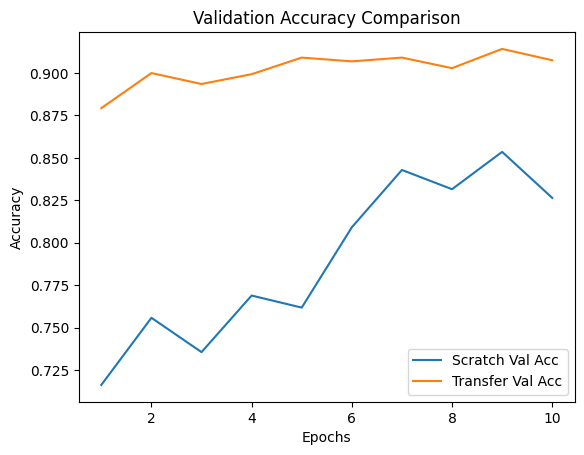

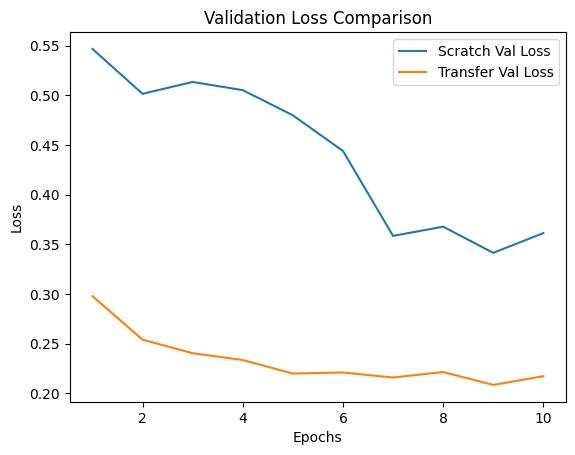

In [14]:
epochs = range(1,11)
plt.plot(epochs, history_scratch['val_acc'], label='Scratch Val Acc')
plt.plot(epochs, history_tl['val_acc'], label='Transfer Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Validation Accuracy Comparison'); plt.legend(); plt.show()

plt.plot(epochs, history_scratch['val_loss'], label='Scratch Val Loss')
plt.plot(epochs, history_tl['val_loss'], label='Transfer Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Validation Loss Comparison'); plt.legend(); plt.show()


Métriques et comparaison
À chaque epoch, calcule et stocke : training loss, accuracy, précision, recall (sur train et val si split).
Trace des courbes : Une pour loss, une pour accuracy, comparant A et B.
Bonus : Matrice de confusion avec confusion_matrix et commente quelques erreurs (ex. "Le modèle confond les chats noirs avec les chiens").